# Using PauliPropagation.jl from Python

This notebook shows how to use the Julia package PauliPropagation.jl from Python. If you're more comfortable with Python but want to use this Julia package for quantum simulations, this approach works pretty well.

## What's this JuliaCall thing?

JuliaCall is just a Python package that lets you call Julia code from Python. It's pretty handy because:

- You can use Julia's fast code without leaving Python
- You can call Julia functions almost like they're Python functions
- It handles converting data between the languages for you

This is great because you can keep working in Python but still use the special features of PauliPropagation.jl when you need them.

## Setting Up

First we need to load juliacall and set up the connection to Julia.

When running this for the first time, it might take a while as Julia gets set up.

In [14]:
# Install juliacall if you haven't already
# Uncomment and run this cell if you need to install the package
#!pip install juliacall

# We'll also need numpy and matplotlib for our Python data manipulation and visualization
import numpy as np
import matplotlib.pyplot as plt

## Setting Up the Python-Julia Bridge

To use Julia from Python, we first need to import and initialize the `juliacall` library. This will:

1. Start a Julia process in the background
2. Give us access to Julia's functionality through the `Main` object
3. Allow us to execute Julia code directly from Python

When using `juliacall` for the first time on a system, it might take a few minutes to set up the Julia environment.

In [15]:
# This part can be annoying the first time - be patient!
from juliacall import Main as jl

print("Julia version:", jl.VERSION)

print("Installing PauliPropagation.jl (grab a coffee, this could take a minute)...")
jl.seval("""
    using Pkg
    if !haskey(Pkg.project().dependencies, "PauliPropagation")
        Pkg.add("PauliPropagation")
    end
""")

jl.seval("using PauliPropagation")
print("Finally! PauliPropagation.jl is loaded")

Julia version: 1.10.9
Installing PauliPropagation.jl (grab a coffee, this could take a minute)...
Finally! PauliPropagation.jl is loaded


## Making Julia Functions More Pythonic

One of the challenges of working with Julia from Python is that function calls can become verbose. Let's create some shortcuts and Python-friendly wrappers to make our code more readable.

We'll use three approaches:
1. Create a shorter module alias (`pp`)
2. Import specific Julia functions into the Python namespace
3. Create helper functions to convert between Python and Julia data types

In [16]:
pp = jl.PauliPropagation

Xsym = jl.Symbol("X")  # For X Pauli
Ysym = jl.Symbol("Y")  # For Y Pauli
Zsym = jl.Symbol("Z")  # For Z Pauli

# This helper function saves a lot of headache
def create_topology_from_python(connections):
    """Convert Python connections to Julia format"""
    jl.seval("""
    function topology_from_python(py_connections)
        # Julia uses 1-indexing, so be careful!
        return convert(Vector{Tuple{Int,Int}}, py_connections)
    end
    """)
    return jl.topology_from_python(connections)

def convert_to_julia_array(python_array):
    """
    Convert a NumPy array to a Julia array.

    Args:
        python_array: NumPy array

    Returns:
        Equivalent Julia array
    """
    return jl.Array(python_array)

print("Created helpful aliases and conversion functions for a more Pythonic experience")

Created helpful aliases and conversion functions for a more Pythonic experience


## Understanding Pauli Strings and Operators

Let's go over some of the core concepts from PauliPropagation.jl that we'll be using. 

The main data types we'll work with are PauliString and PauliSum. A PauliString is just a tensor product of Pauli operators $X$, $Y$, $Z$, and $I$ with a coefficient, like:

$0.5 \cdot X_1 \otimes Y_2 \otimes Z_3 \otimes I_4 \otimes ... \otimes I_{10}$

When you have multiple PauliStrings added together, that's a PauliSum:

$0.5 \cdot X_1 \otimes Z_2 + 1.2 \cdot Y_3 \otimes Y_4 + 0.7 \cdot Z_1 \otimes Z_5$

The quantum circuit is basically a sequence of gates acting on qubits. And the topology defines which qubits can interact with each other (this matters for two-qubit gates).

Let's create a simple Pauli operator and see what we get:

In [17]:
# Let's create a 10-qubit system for our examples
nqubits = 10

# A PauliString representing Z on the 5th qubit (indices are 1-based in Julia)
observable = pp.PauliString(nqubits, Zsym, 5)
print("Single Z observable:", observable)

# We can also create more complex observables
# Format: PauliString(nqubits, [types], [positions], coefficient)
complex_obs = pp.PauliString(nqubits, [Xsym, Ysym, Zsym], [1, 3, 7], 2.5)
print("Complex observable:", complex_obs)

# Converting to a PauliSum (needed for propagation)
pauli_sum = pp.PauliSum(observable)
print("Type of pauli_sum:", type(pauli_sum))

Single Z observable: PauliString(nqubits: 10, 1.0 * IIIIZIIIII)
Complex observable: PauliString(nqubits: 10, 2.5 * XIYIIIZIII)
Type of pauli_sum: <class 'juliacall.AnyValue'>


## Creating Custom Topologies with Python Lists

One thing I really like about using Python with this Julia package is how easy it is to define custom qubit topologies. A topology is just fancy talk for "which qubits can talk to each other", super important for real quantum hardware where not every qubit connects to every other one.

In PauliPropagation.jl, you'd normally define these connections using Julia's syntax, but I find it easier to just use Python lists of tuples. Plus, we can visualize our topology right in the notebook (which honestly helped me debug more than once).

Let's create a simple ring of qubits with a few extra long-range connections:

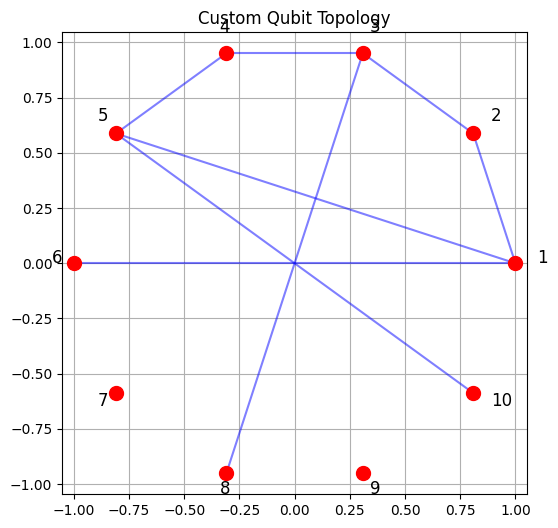

Created custom topology with 8 connections
For comparison, the standard brick layer topology has 10 connections


In [18]:
# Each tuple represents a connection between two qubits (1-indexed)
custom_connections = [(1, 2), (2, 3), (3, 4), (4, 5), (5, 1),  # Ring
                      (1, 6), (3, 8), (5, 10)]  # Some long-range connections

# Converting to Julia topology using our helper function
custom_topology = create_topology_from_python(custom_connections)

# For comparison, let's also create a standard brick layer topology
brick_topology = pp.bricklayertopology(nqubits, periodic=True)

plt.figure(figsize=(6, 6))
plt.title("Custom Qubit Topology")

angles = np.linspace(0, 2*np.pi, nqubits, endpoint=False)
positions = {i+1: (np.cos(angle), np.sin(angle)) for i, angle in enumerate(angles)}

for q1, q2 in custom_connections:
    x1, y1 = positions[q1]
    x2, y2 = positions[q2]
    plt.plot([x1, x2], [y1, y2], 'b-', alpha=0.5)


for i, (x, y) in positions.items():
    plt.plot(x, y, 'ro', markersize=10)
    plt.text(x*1.1, y*1.1, f"{i}", fontsize=12)

plt.axis('equal')
plt.grid(True)
plt.show()

print(f"Created custom topology with {len(custom_connections)} connections")
print(f"For comparison, the standard brick layer topology has {jl.length(brick_topology)} connections")

## Basic Example: 

Alright, time to see this thing in action! Let's do what I was actually trying to accomplish with this whole setup - running a quantum circuit and seeing what happens to our observable.

The main thing PauliPropagation.jl is good at is taking some quantum observable (like a Z measurement on a specific qubit) and figuring out what happens to it when you run it through a quantum circuit. I use this all the time when I want to know expectation values without having to simulate the full wavefunction (which gets ridiculous at like 30+ qubits).

Here's what we're going to do:
1. Pick an observable (I'll just use a Z operator on the middle qubit)
2. Build a circuit (I like the TFIM model because it's physically meaningful)
3. Set some parameters (honestly just using constant values to keep things simple)
4. Run the propagation
5. See what we get!

I ran into a bunch of type conversion issues the first time I tried this, so I've included some tricks below that saved me a lot of headaches.

In [ ]:
# We'll use the 10-qubit system defined earlier
print(f"System size: {nqubits} qubits")

# Our observable is Z on the middle qubit
observable = pp.PauliString(nqubits, Zsym, nqubits // 2)
print("Observable:", observable)

# We'll use our custom topology defined above
print("Using custom topology for our circuit")

# Creating a Tilted Transverse Field Ising Model (TFIM) circuit with 5 layers
# This is a more realistic and non-trivial circuit compared to simple examples
nlayers = 5
circuit = pp.tiltedtfitrottercircuit(nqubits, nlayers, topology=custom_topology)
num_parameters = int(pp.countparameters(circuit))
print(f"Circuit has {num_parameters} parameters")

# Creating circuit parameters using NumPy (Pythonic way)
dt = 0.1
# Creating parameters as a NumPy array
parameters_numpy = np.full(num_parameters, dt)
print(f"Created parameters using NumPy: {parameters_numpy[:5]}...")

# Converting NumPy array to Julia array for compatibility
parameters_julia = convert_to_julia_array(parameters_numpy)

# The truncation parameters
max_weight = 6  # Maximum weight of Pauli strings to keep
min_abs_coeff = 1e-4  # Minimum absolute coefficient value to keep

# When propagating a PauliString, propagate returns a new PauliSum
pauli_sum_result = pp.propagate(
    circuit, observable, parameters_julia,
    max_weight=max_weight, min_abs_coeff=min_abs_coeff
)
print(f"Result has {int(jl.length(pauli_sum_result))} Pauli terms")

# Calculating the expectation value (overlap with |0>\otimes^{n} state)
overlap = float(pp.overlapwithzero(pauli_sum_result))
print(f"Expectation value: {overlap:.6f}")

System size: 10 qubits
Observable: PauliString(nqubits: 10, 1.0 * IIIIZIIIII)
Using custom topology for our circuit
Circuit has 140 parameters
Created parameters using NumPy: [0.1 0.1 0.1 0.1 0.1]...
Result has 125 Pauli terms
Expectation value: 0.910896


## Understanding Propagation: 

When we call `pp.propagate()`, the following steps occur:

1. **Transformation to Heisenberg Picture**: Instead of evolving quantum states, we evolve the observable
2. **Pauli Algebra**: Each gate in the circuit transforms the Pauli operators according to specific rules
3. **Term Generation**: As the circuit depth increases, more Pauli terms are generated
4. **Truncation**: Terms with small coefficients or high weight are discarded to maintain efficiency

This approach allows us to simulate larger quantum systems than would be possible with direct state vector simulation, especially for sparse observables.

### Why Truncation Matters

Without truncation, the number of terms would grow exponentially with circuit depth, making the simulation computationally intractable. The two main truncation methods are:

- **Weight truncation**: Remove Pauli strings with more than `max_weight` non-identity operators
- **Coefficient truncation**: Remove terms with coefficients below `min_abs_coeff`

Finding the right balance between accuracy and computational efficiency is a key challenge.

max_weight=2: 27 terms, overlap = 0.899743
max_weight=4: 121 terms, overlap = 0.910896
max_weight=6: 125 terms, overlap = 0.910896
max_weight=8: 125 terms, overlap = 0.910896


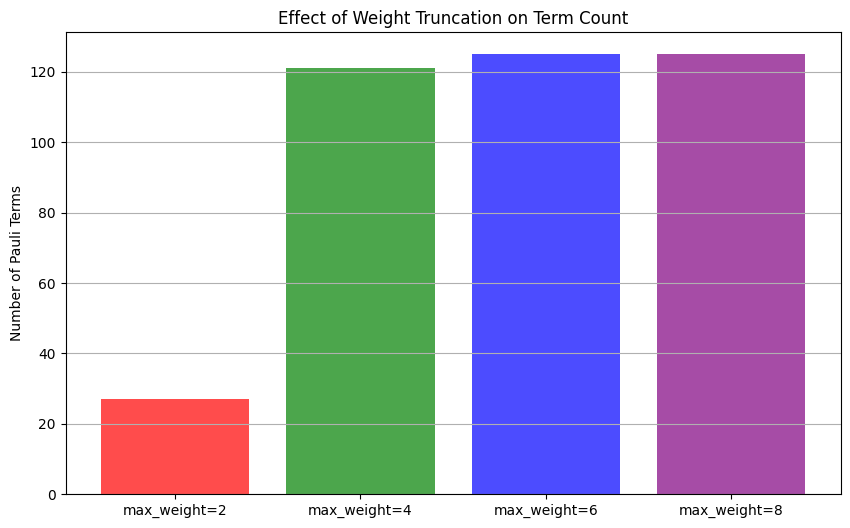

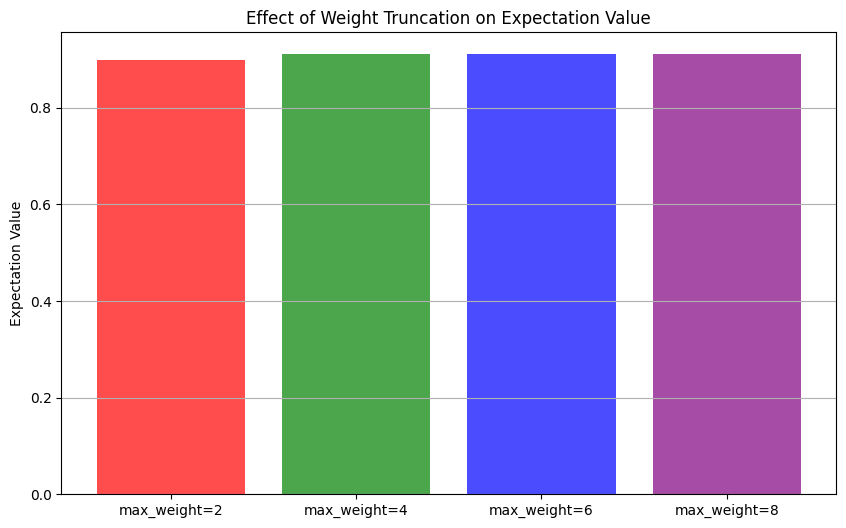

In [20]:
# Let's examine how the number of terms grows with different truncation settings
trunc_settings = [
    {"max_weight": 2, "min_abs_coeff": 1e-4, "color": "red", "label": "max_weight=2"},
    {"max_weight": 4, "min_abs_coeff": 1e-4, "color": "green", "label": "max_weight=4"},
    {"max_weight": 6, "min_abs_coeff": 1e-4, "color": "blue", "label": "max_weight=6"},
    {"max_weight": 8, "min_abs_coeff": 1e-4, "color": "purple", "label": "max_weight=8"}
]

results = []
for setting in trunc_settings:
    result = pp.propagate(
        circuit, observable, parameters_julia,
        max_weight=setting["max_weight"],
        min_abs_coeff=setting["min_abs_coeff"]
    )
    results.append({
        "setting": setting,
        "num_terms": int(jl.length(result)),
        "overlap": float(pp.overlapwithzero(result))
    })
    print(f"{setting['label']}: {results[-1]['num_terms']} terms, overlap = {results[-1]['overlap']:.6f}")

plt.figure(figsize=(10, 6))
for result in results:
    setting = result["setting"]
    plt.bar(setting["label"], result["num_terms"], color=setting["color"], alpha=0.7)
plt.ylabel("Number of Pauli Terms")
plt.title("Effect of Weight Truncation on Term Count")
plt.grid(True, axis="y")
plt.show()

plt.figure(figsize=(10, 6))
for result in results:
    setting = result["setting"]
    plt.bar(setting["label"], result["overlap"], color=setting["color"], alpha=0.7)
plt.ylabel("Expectation Value")
plt.title("Effect of Weight Truncation on Expectation Value")
plt.grid(True, axis="y")
plt.show()

## Working with Data Between Python and Julia

A key aspect of using `juliacall` is understanding how to convert data between Python and Julia. Here we'll explore some common techniques:

1. **Converting Julia arrays to NumPy arrays**
2. **Converting NumPy arrays to Julia arrays**
3. **Working with Julia objects in Python**
4. **Accessing Julia documentation from Python**

In [21]:
julia_random = jl.rand(10)
print("Julia array type:", type(julia_random))

numpy_array = np.array(julia_random)
print("NumPy array type:", type(numpy_array))
print("NumPy array content:", numpy_array)

numpy_to_julia = convert_to_julia_array(numpy_array * 2)
print("Converted back to Julia with doubled values:", numpy_to_julia)

jl.seval("""
function count_pauli_terms(ps)
    return length(ps)
end
""")

num_terms = int(jl.count_pauli_terms(pauli_sum_result))
print(f"Number of Pauli terms in our result (using Julia function): {num_terms}")

help_text = jl.seval("@doc PauliPropagation.propagate")
print("\nDocumentation for propagate function:")
help_text_str = str(jl.string(help_text))
print("\n".join(help_text_str.split("\n")[:10]) + "\n...")

Julia array type: <class 'juliacall.VectorValue'>
NumPy array type: <class 'numpy.ndarray'>
NumPy array content: [0.18993515 0.45247219 0.97395359 0.22762265 0.18583663 0.18875782
 0.46881634 0.62995889 0.37831908 0.01511564]
Converted back to Julia with doubled values: [0.37987029800561234, 0.904944373496098, 1.9479071861844757, 0.45524529729234064, 0.37167325216735336, 0.3775156332509759, 0.9376326873425438, 1.2599177701519626, 0.7566381586936572, 0.030231275901705157]
Number of Pauli terms in our result (using Julia function): 125

Documentation for propagate function:
```
propagate(circ, pstr::PauliString, thetas=nothing; max_weight=Inf, min_abs_coeff=1e-10, max_freq=Inf, max_sins=Inf, customtruncfunc=nothing, kwargs...)
```

Propagate a `PauliString` through the circuit `circ` in the Heisenberg picture.  This means that the circuit is applied to the Pauli string in reverse order, and the action of each gate is its conjugate action. Parameters for the parametrized gates in `circ` a

## Efficient Layer-wise Evolution:

Now we'll demonstrate a more sophisticated and efficient approach to quantum simulation: layer-wise evolution.

Instead of creating a circuit with multiple layers and propagating through it once, we:

1. Create a single-layer circuit
2. Repeatedly propagate through this single layer
3. Track the expectation value after each layer

This approach is:
- More computationally efficient
- Closer to how real quantum systems evolve in time
- Gives us insight into the dynamics of the system

We'll implement this using a more Pythonic coding style with NumPy arrays.

Let's watch the evolution layer by layer...
Layer 0, Overlap: 1.0, Terms: 1
Layer 1, Overlap: 0.9950, Terms: 12
Layer 5, Overlap: 0.9109, Terms: 125
Layer 10, Overlap: 0.8647, Terms: 839
Layer 15, Overlap: 0.9101, Terms: 3421
Layer 20, Overlap: 0.9113, Terms: 8751


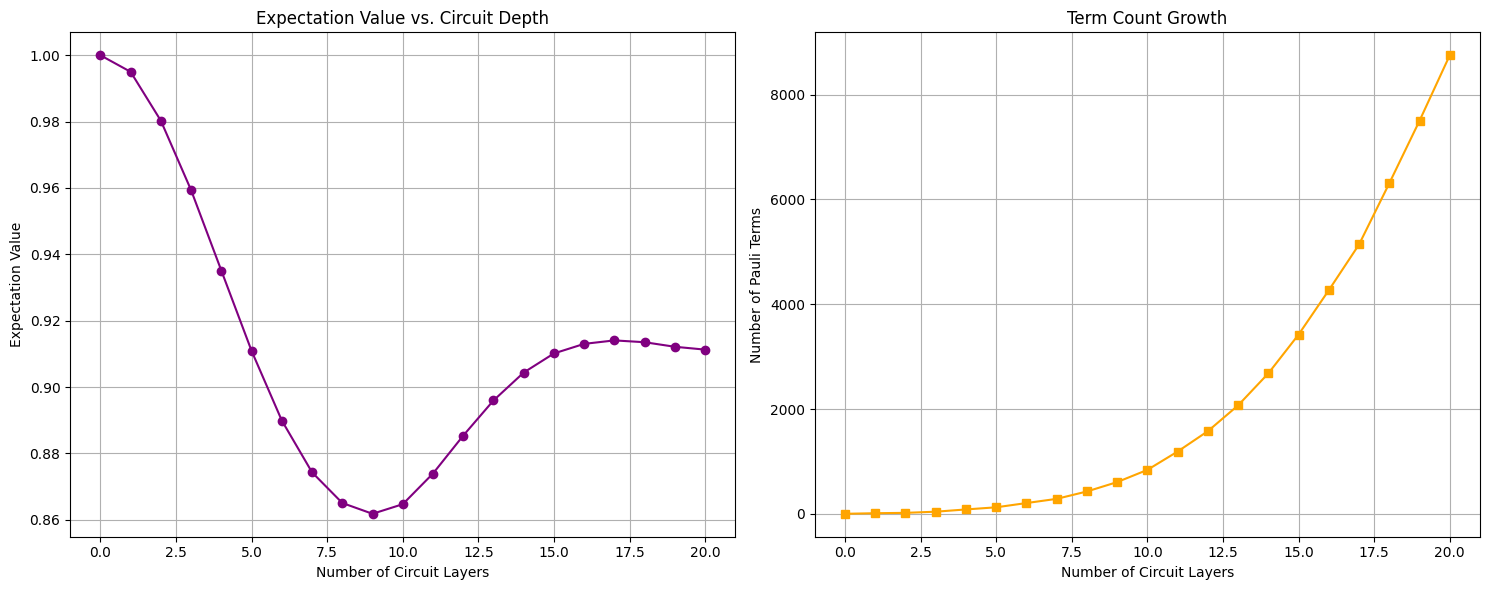

In [22]:
print("Let's watch the evolution layer by layer...")

max_layers = 20
dt = 0.1

single_layer = pp.tiltedtfitrottercircuit(nqubits, 1, topology=custom_topology)
num_layer_params = int(pp.countparameters(single_layer))
numpy_layer_params = np.full(num_layer_params, dt)
julia_layer_params = convert_to_julia_array(numpy_layer_params)

psum = pp.PauliSum(observable)

layer_indices = list(range(0, max_layers + 1))
expectation_values = [float(pp.overlapwithzero(psum))]
term_counts = [int(jl.length(psum))]
print(f"Layer 0, Overlap: {expectation_values[0]}, Terms: {term_counts[0]}")

for layer in range(1, max_layers + 1):
    psum = pp.propagate(
        single_layer, psum, julia_layer_params,
        max_weight=max_weight, min_abs_coeff=min_abs_coeff
    )

    current_overlap = float(pp.overlapwithzero(psum))
    current_terms = int(jl.length(psum))
    expectation_values.append(current_overlap)
    term_counts.append(current_terms)

    if layer % 5 == 0 or layer == 1 or layer == max_layers:
        print(f"Layer {layer}, Overlap: {current_overlap:.4f}, Terms: {current_terms}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))


ax1.plot(layer_indices, expectation_values, 'o-', color='purple')
ax1.set_xlabel('Number of Circuit Layers')
ax1.set_ylabel('Expectation Value')
ax1.set_title('Expectation Value vs. Circuit Depth')
ax1.grid(True)


ax2.plot(layer_indices, term_counts, 's-', color='orange')
ax2.set_xlabel('Number of Circuit Layers')
ax2.set_ylabel('Number of Pauli Terms')
ax2.set_title('Term Count Growth')
ax2.grid(True)

plt.tight_layout()
plt.show()

## Comparing Truncation Effects:

One of the most important considerations when using Pauli propagation is choosing appropriate truncation parameters. Let's systematically compare different truncation settings and visualize their effects.

We'll compare:
- Different `max_weight` settings (2, 4, 6, 8)
- Same `min_abs_coeff` setting (1e-4)

This will help us understand the trade-off between accuracy and computational cost.

Max weight 2: 71 Pauli terms after 20 layers
Max weight 4: 2267 Pauli terms after 20 layers
Max weight 6: 8751 Pauli terms after 20 layers
Max weight 8: 10530 Pauli terms after 20 layers


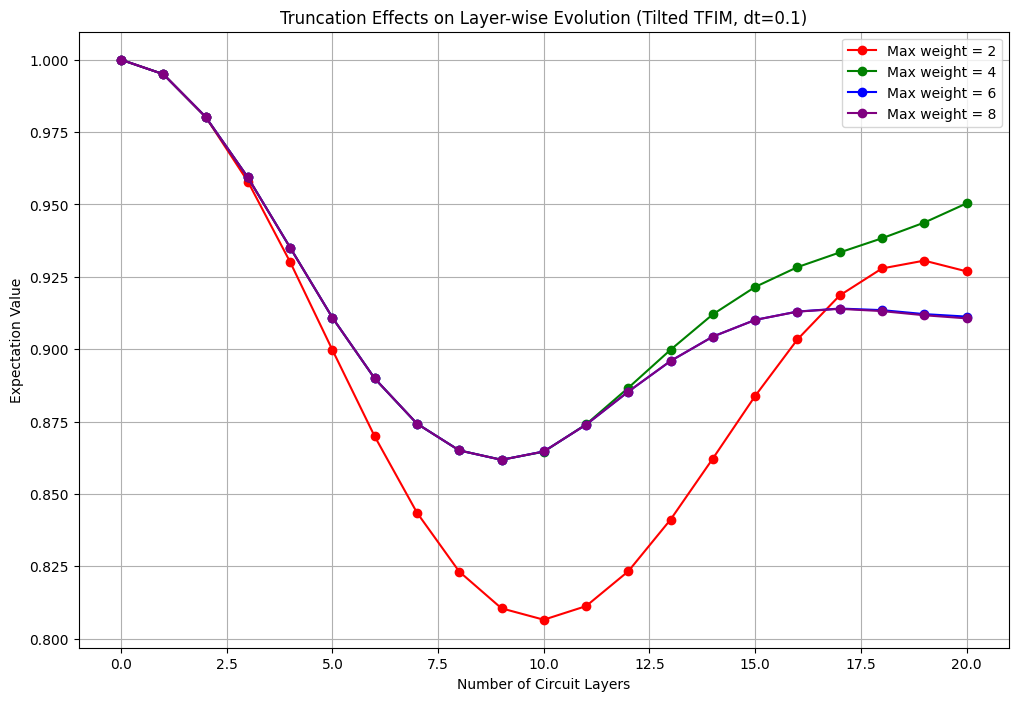

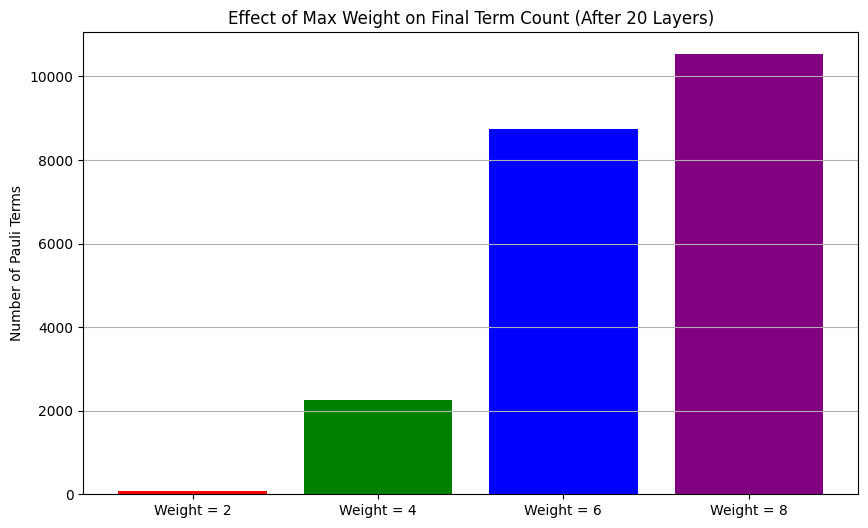

In [23]:
weight_settings = [2, 4, 6, 8]
colors = ['red', 'green', 'blue', 'purple']

plt.figure(figsize=(12, 8))

final_term_counts = []

for idx, current_max_w in enumerate(weight_settings):
    psum_trunc = pp.PauliSum(observable)

    expectation_values_trunc = [float(pp.overlapwithzero(psum_trunc))]
    for layer in range(1, max_layers + 1):
        psum_trunc = pp.propagate(
            single_layer, psum_trunc, julia_layer_params,
            max_weight=current_max_w, min_abs_coeff=min_abs_coeff
        )
        expectation_values_trunc.append(float(pp.overlapwithzero(psum_trunc)))

    term_count = int(jl.length(psum_trunc))
    final_term_counts.append(term_count)
    print(f"Max weight {current_max_w}: {term_count} Pauli terms after {max_layers} layers")

    plt.plot(layer_indices, expectation_values_trunc, 'o-', color=colors[idx],
             label=f'Max weight = {current_max_w}')

plt.xlabel('Number of Circuit Layers')
plt.ylabel('Expectation Value')
plt.title(f'Truncation Effects on Layer-wise Evolution (Tilted TFIM, dt={dt})')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
for idx, (weight, count) in enumerate(zip(weight_settings, final_term_counts)):
    plt.bar(f"Weight = {weight}", count, color=colors[idx])
plt.ylabel('Number of Pauli Terms')
plt.title(f'Effect of Max Weight on Final Term Count (After {max_layers} Layers)')
plt.grid(True, axis='y')
plt.show()

## Limitations I've Run Into

While this approach works well, I've hit a few snags worth mentioning:

- There's some overhead going back and forth between Python and Julia, not huge, but noticeable
- Memory usage can spike when you have lots of Pauli terms 
- The error messages when something breaks can be pretty confusing, they often don't tell you which side (Python or Julia) had the issue

This approach works best when:
- Your observable doesn't spread out too much during evolution
- You're working with systems too big for direct state vector methods
- You care about specific observables, not the whole quantum state

If you go this route, you'll need to pick up:
- A bit of Julia's type system (enough to understand error messages)
- The basics of the Heisenberg picture for evolution
- How to balance truncation parameters for your specific problem

## Summary and Next Steps

In this notebook, we've demonstrated how to use `PauliPropagation.jl` from Python using `juliacall`. We've covered:

- Setting up the Julia-Python bridge
- Creating Pauli operators and quantum circuits
- Converting between Python and Julia data structures
- Implementing efficient layer-wise evolution
- Understanding and comparing truncation effects

### Further Exploration Ideas
- Try different circuit architectures and observables
- Benchmark against other quantum simulation methods
- Implement custom circuit designs using Python data structures
- Study how different observables evolve through the same circuit
- Explore more advanced truncation strategies

For more information, you can refer to the documentation of PauliPropagation.jl and JuliaCall.